In [31]:
from IPCA import IPCA
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import FinanceDataReader as fdr

In [131]:
kospi_ = fdr.DataReader('KS11', '2018-01-03')
kosdaq_ = fdr.DataReader('KQ11', '2018-01-03')
dow_ = fdr.DataReader('DJI', '2018-01-03')
nasdaq_ = fdr.DataReader('IXIC', '2018-01-03')
SE_ = fdr.DataReader('005930', '2018-01-03')
kakao_ = fdr.DataReader('035720', '2018-01-03')
btc_ = fdr.DataReader('BTC/KRW', '2018-01-03')

In [132]:
def gen_features(original):
    df = original.copy()
    
    df = df.reindex(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
    
    df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].apply(np.log).diff()
    df['HL'] = df['High'] - df['Low']
    df['MA5'] = df['Close'].rolling(5, min_periods=1).mean()
    df['disp'] = df['Close'] - df['MA5']
    df['std5'] = df['Close'].rolling(5, min_periods=1).std()
    df = df.fillna(method='ffill')
    df = df.dropna()
    
    return df

kospi = gen_features(kospi_)
kosdaq = gen_features(kosdaq_)
dow = gen_features(dow_)
nasdaq = gen_features(nasdaq_)
SE = gen_features(SE_)
kakao = gen_features(kakao_)
btc = gen_features(btc_)

In [133]:
def make_sets(originals, t):
    r_list = []
    z_list = []
    
    for original in originals:
        arr = original.copy()

        arr = arr.iloc[:t+1, :]
        r = arr['Close'].iloc[1:].values
        z = arr.iloc[:t, :].values

        r_list.append(r)
        z_list.append(z)
        
    r = np.array(r_list)
    r = np.expand_dims(r, axis=2)
    z = np.array(z_list)
    
    return np.transpose(r, (1,0,2)), np.transpose(z, (1,0,2)) 

r, z = make_sets([kospi, kosdaq, dow, nasdaq, SE, kakao, btc], 60)
r.shape, z.shape

((60, 7, 1), (60, 7, 9))

In [134]:
r_fit = r[:-1]
z_fit = z[:-1]
model = IPCA(r=r_fit, z=z_fit, K=3, restricted=True)
history = model.fit(500, verbose_interval=100)

EPOCHS: 0
error: 0.076329115712171
EPOCHS: 100
error: 0.04072623772789298
EPOCHS: 200
error: 0.04070702673989444
EPOCHS: 300
error: 0.040705093566456296
EPOCHS: 400
error: 0.0407037867726958
******************************
Ideal Epochs: 499
Ideal error: 0.040702835185143886


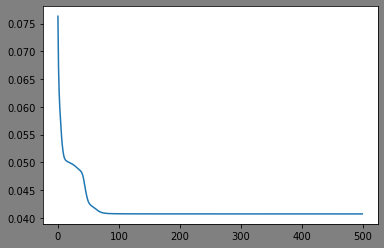

In [135]:
plt.plot(history['loss'])
plt.show()

In [136]:
# forecasting
r_post = r[-1:]
z_post = z[-1:]
r_fore = model.forecast(z_post)

In [137]:
r_fit.shape

(59, 7, 1)

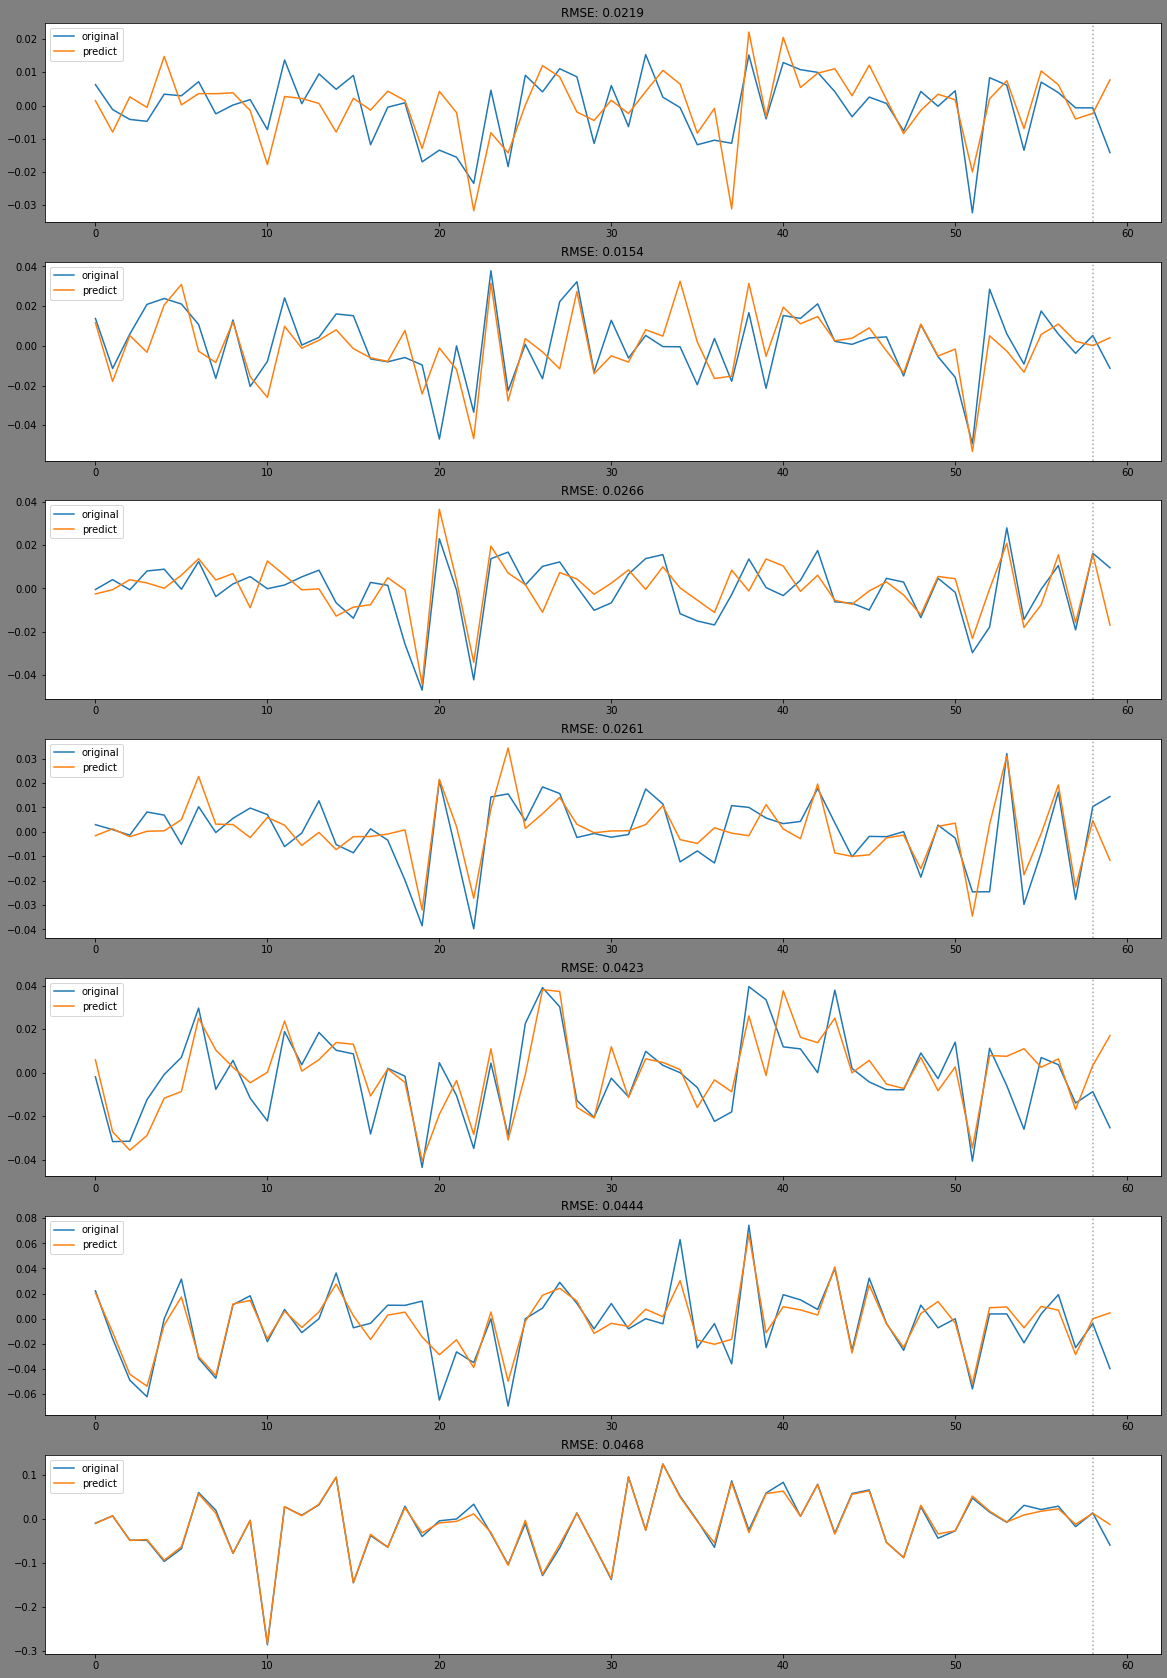

In [140]:
T = model.T
N = model.N
r_hat = history['predict']

plt.figure(figsize=(20, 30))
plt.rcParams['figure.facecolor'] = 'gray'
for item in range(0, N):
#     original = np.exp(np.hstack([r_fit[:, item, 0], r_post[:, item, 0]]).cumsum())
#     predict = np.exp(np.hstack([r_hat[:, item, 0], r_fore[:, item, 0]]).cumsum())
    original = np.hstack([r_fit[:, item, 0], r_post[:, item, 0]])
    predict = np.hstack([r_hat[:, item, 0], r_fore[:, item, 0]])

    plt.subplot(N, 1, item + 1)
    plt.title('RMSE: {}'.format(np.around(
        np.mean(np.abs(original[-1] - predict[-1])), 4)))
    plt.plot(original, label='original')
    plt.plot(predict, label='predict')
    plt.axvline(T - 1, c='gray', linestyle=':', alpha=0.7)
    plt.legend()

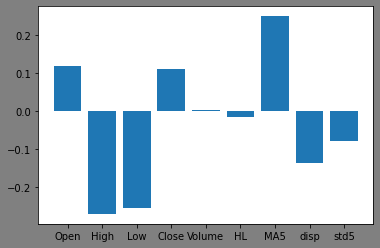

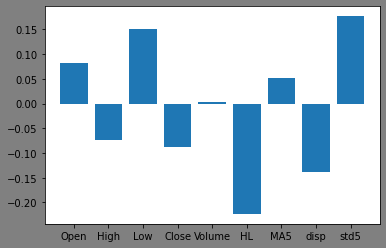

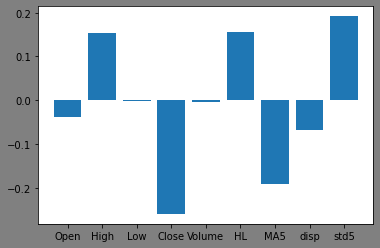

In [141]:
gamma = history['estimators']['gamma']
for k in range(model.K):
    plt.bar(np.arange(gamma.shape[0]), gamma[:, k])
    plt.xticks(np.arange(gamma.shape[0]), kospi.columns)
    plt.show()

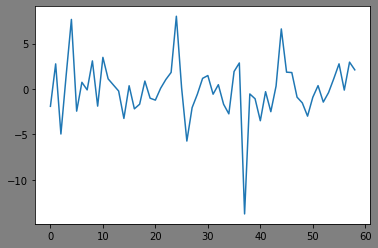

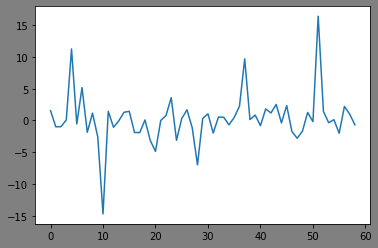

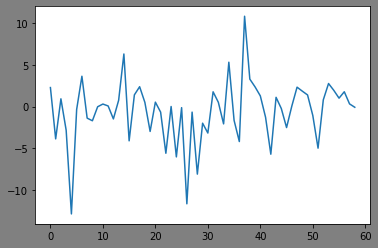

In [142]:
f = history['estimators']['f']
for k in range(model.K):
    plt.plot(f[:, k, 0])
    plt.show()